%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Reading library from /Users/isabelangelo/.specmatchemp/library.h5


/Users/isabelangelo/opt/anaconda3/lib/python3.8/site-packages/specmatchemp/spectrum.py:590: RuntimeWarning: invalid value encountered in sqrt
  serr = hdu[0].data**(1/2.)
/Users/isabelangelo/opt/anaconda3/lib/python3.8/site-packages/specmatchemp/spectrum.py:56: RuntimeWarning: invalid value encountered in cast
  self.mask = np.empty_like(s).astype(bool)


Shifting spectrum cks-k05625_rj204.99
Attempting shift to spectrum nso_adj, median cross-correlation peak = 2.52
Attempting shift to spectrum j72.718_adj, median cross-correlation peak = 2.76
Attempting shift to spectrum j26.532_adj, median cross-correlation peak = 1.31
Attempting shift to spectrum j59.1926_adj, median cross-correlation peak = 1.64
Best reference for shifting: j72.718_adj
Shifting entire spectrum


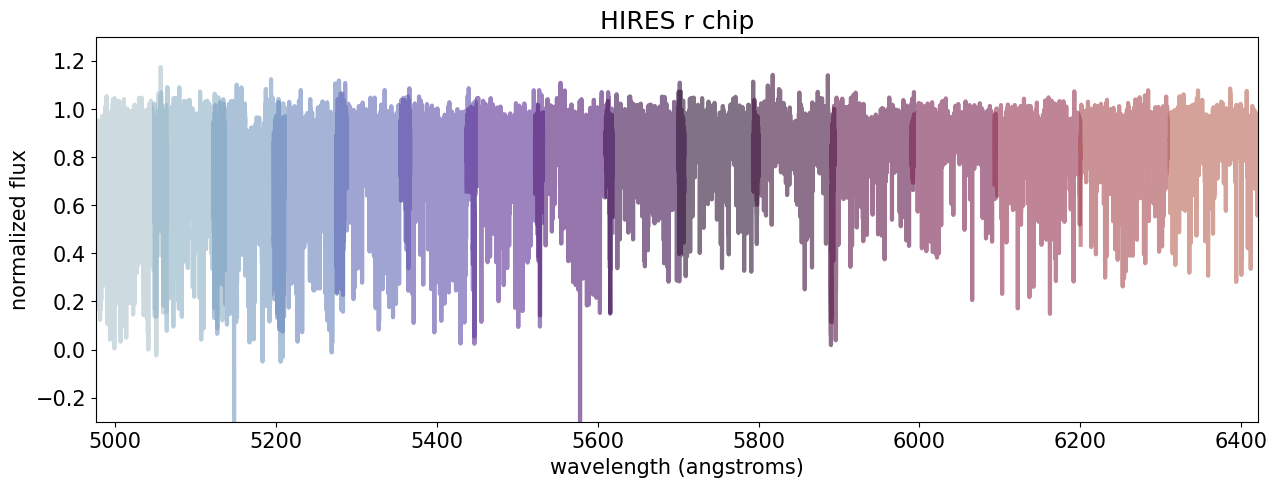

In [1]:
from specmatchemp import SHIFT_REFERENCES
from specmatchemp.library import read_hdf as read_sm_lib
from specmatchemp.shift import shift, bootstrap_shift
from specmatchemp.spectrum import read_fits, read_hires_fits
from specmatchemp.spectrum import Spectrum
from specmatchemp.specmatch import SpecMatch
import os
import glob

%pylab inline
import matplotlib
from matplotlib import cm

# load specmatch library
lib = read_sm_lib()
# load shifted reference spectra
ref_specs = [read_fits(os.path.join('/Users/isabelangelo/.specmatchemp/shifted_spectra/',
             r[0] + '_adj.fits')) for r in SHIFT_REFERENCES]

# Read targets to shift
cks_spectrum_filenames = glob.glob('./data/cks-spectra/*rj*.fits')

def shift_and_resample_orders(filename):
    # load target to shift
    target = read_hires_fits(filename)

    ## extract order for bootstrap shift
    bootstrap_order = target.cut(5120, 5200)

    # Shift single order to determine best reference
    bootstrap_shift_data = {}
    shifted_bs_order = bootstrap_shift(bootstrap_order, ref_specs, store=bootstrap_shift_data)
    best_ref_spec = ref_specs[bootstrap_shift_data['shift_reference']]

    shifted_and_resampled_orders = []
    for i in range(target.w.shape[0]):
        order = Spectrum(target.w[i], target.s[i], target.serr[i], target.mask[i])
        shifted_order = shift(order, best_ref_spec)
        
        # extend spectrum to correct size for rescaling
        w_to_resample_to = target.w[i][1:-1]
        extended_w = np.linspace(shifted_order.w[0], shifted_order.w[-1], len(w_to_resample_to))
        extended_order =  shifted_order.extend(extended_w)

        # resample spectrum onto library wavelength
        resampled_order = extended_order.rescale(w_to_resample_to)
        
        # store shifted, resampled order
        shifted_and_resampled_orders.append(resampled_order)
        
    return shifted_and_resampled_orders

def plot_orders(orders):
    rcParams['font.size']=15
    norm = matplotlib.colors.Normalize(vmin=-2, vmax=20)
    figure(figsize=(15,5))
    for i in range(len(orders)):
        order = orders[i]
        plot(order.w, order.s, c=cm.twilight(norm(i)), lw=3, alpha=0.6)
    xlabel('wavelength (angstroms)');ylabel('normalized flux')
    xlim(shifted_orders[0].w[0], orders[-1].w[-1])
    title('HIRES r chip')
    ylim(-0.3,1.3)
    

shifted_orders = shift_and_resample_orders(cks_spectrum_filenames[0])
plot_orders(shifted_orders)

Text(0, 0.5, 'normalized flux, scaled')

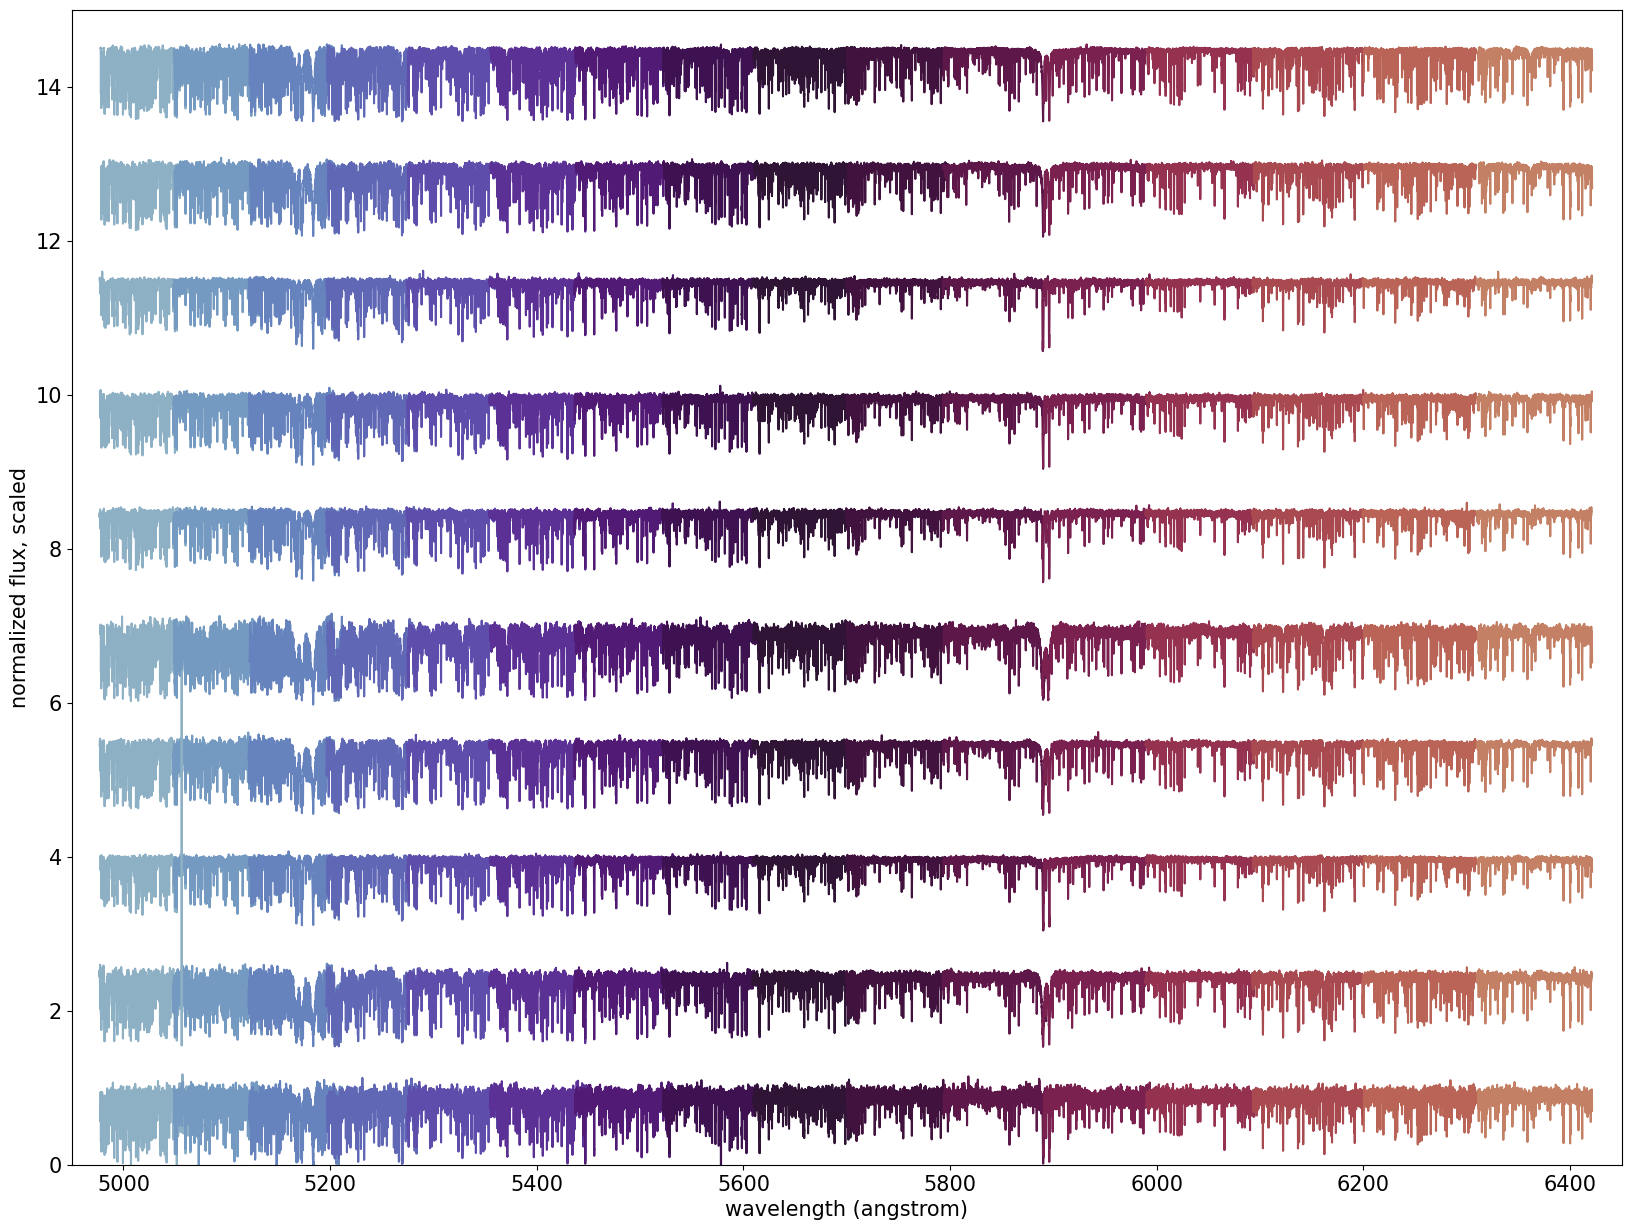

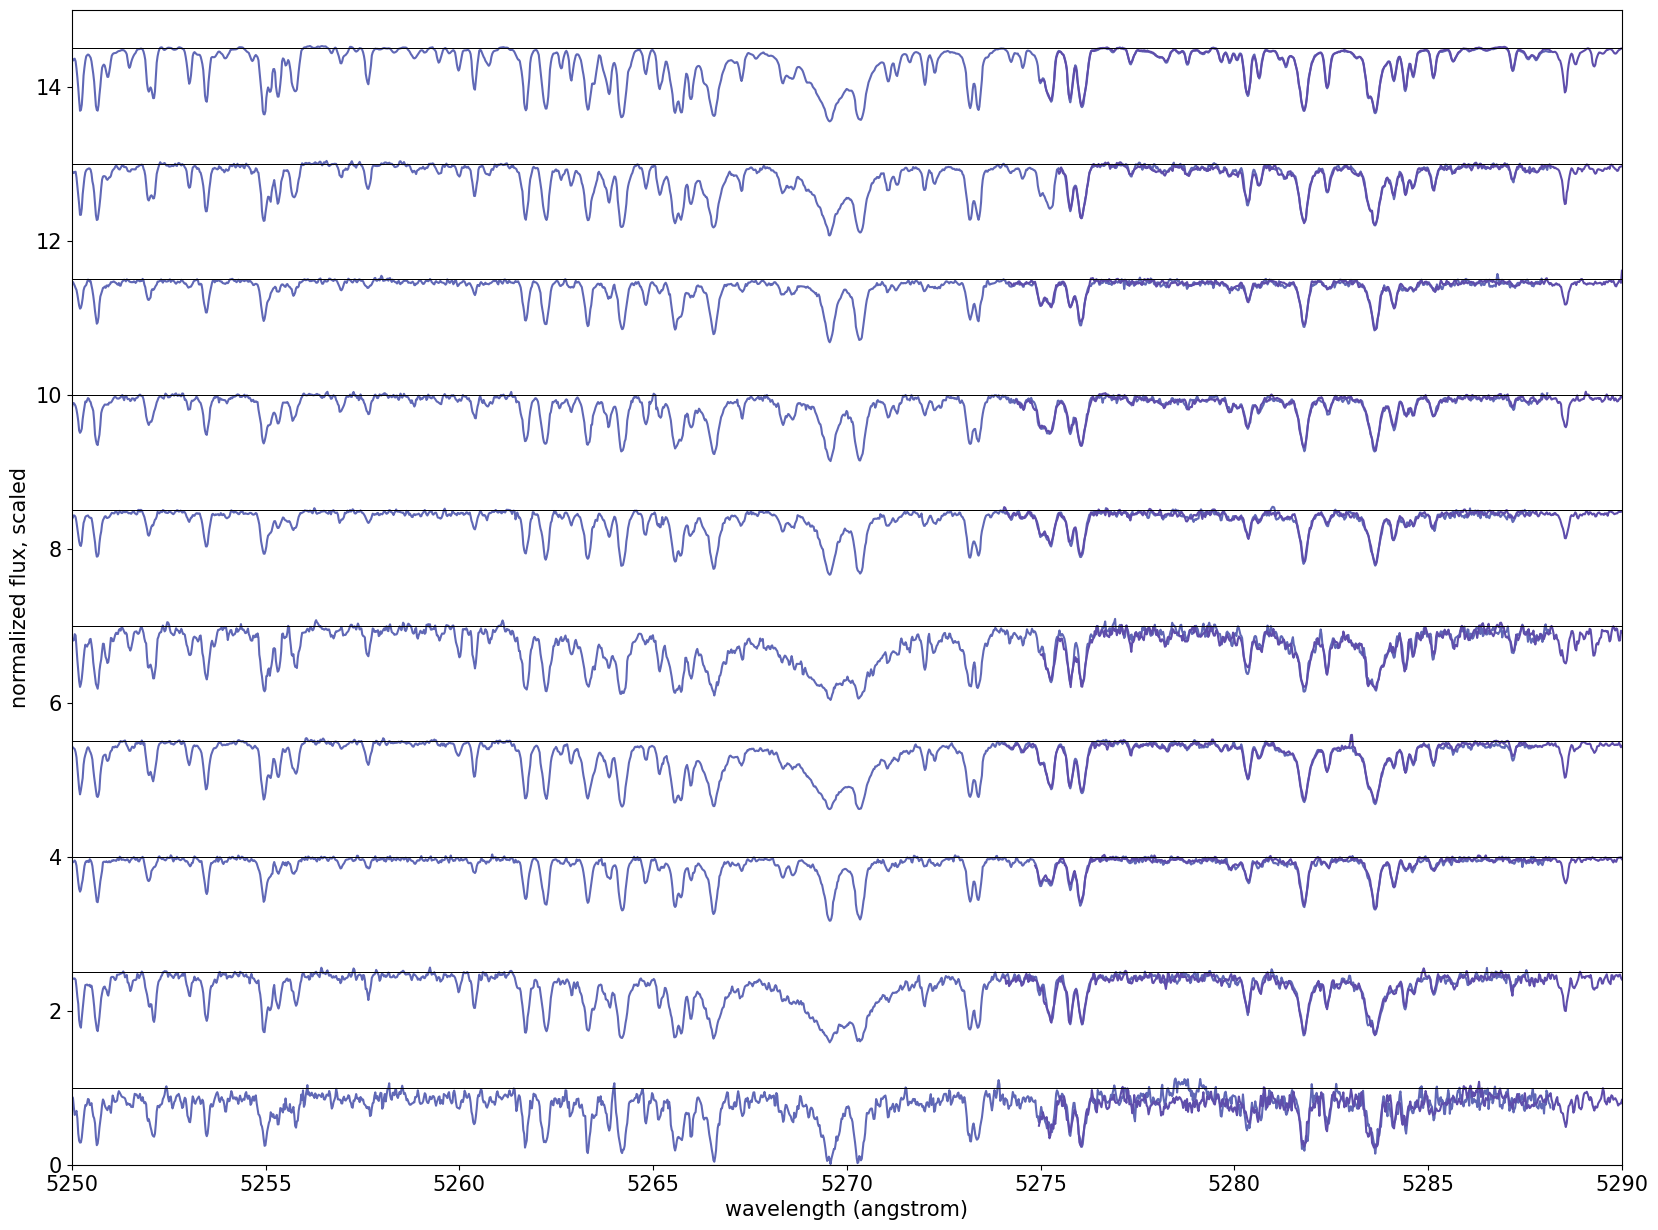

In [2]:
# here is a plot of 10
# I'm going to first change the colors
# then I'm going to change the figure sizes
# to see if everything is working.
from astropy.io import fits

shifted_path = './data/cks-spectra_shifted_resampled_r'
test_filenames = glob.glob(shifted_path+'/order1/*.fits')
shifted_targets = [i.split('/')[4].replace('.fits','') for i in test_filenames][:10]
norm = matplotlib.colors.Normalize(vmin=-2, vmax=20)

figure(figsize=(20,15))
for i in range(len(shifted_targets)):
    target = shifted_targets[i]
    for order_n in range(1,17):
        order_filename = '{}/order{}/{}.fits'.format(shifted_path,order_n,target)
        order_data = fits.open(order_filename)[1].data
        plot(order_data.w, order_data.s+i*1.5, c=cm.twilight(norm(order_n)))
ylim(0,15);xlim(4950,6450)
xlabel('wavelength (angstrom)');ylabel('normalized flux, scaled')

figure(figsize=(20,15))
for i in range(len(shifted_targets)):
    target = shifted_targets[i]
    for order_n in range(1,17):
        order_filename = '{}/order{}/{}.fits'.format(shifted_path,order_n,target)
        order_data = fits.open(order_filename)[1].data
        axhline(i*1.5+1, lw=0.4, color='k')
        plot(order_data.w, order_data.s+i*1.5, c=cm.twilight(norm(order_n)))
ylim(0,15);xlim(5250,5290)
xlabel('wavelength (angstrom)');ylabel('normalized flux, scaled')

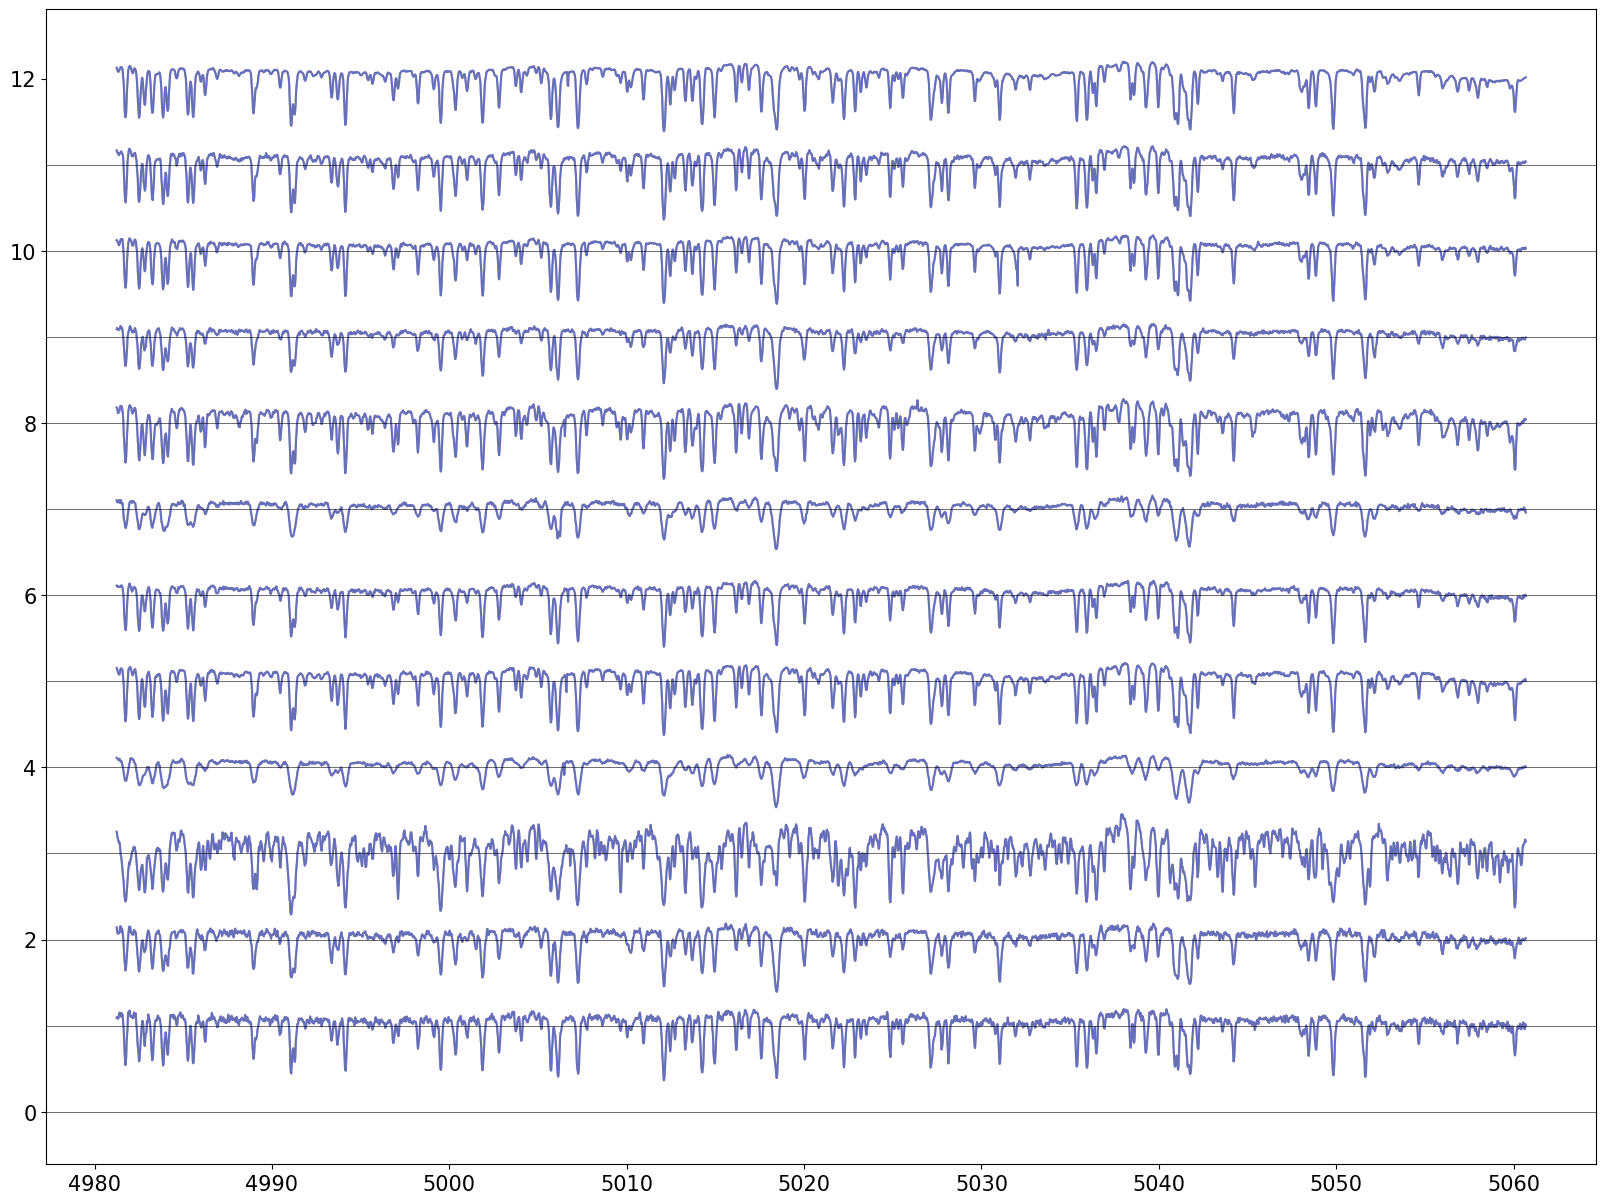

In [11]:
# next I'm going to read in the wavelet transforms of order 1!
import pandas as pd
training_flux = pd.read_csv('./data/cks-spectra_dataframes/training_flux_order1.csv')
reference_w = fits.open('./data/cannon_training_data/cannon_reference_w.fits')[0].data
w1 = reference_w[0]
i=0

figure(figsize=(20,15))
for target in training_flux.columns[1:13]:
    axhline(i, lw=0.4, color='k')
    plot(w1, training_flux[target]+i, c=cm.twilight(norm(4)), alpha=0.5)
    plot(w1, training_flux[target]+i, c=cm.twilight(norm(4)), alpha=0.9)
    i+=1

Text(0, 0.5, 'normalized flux (+ offset)')

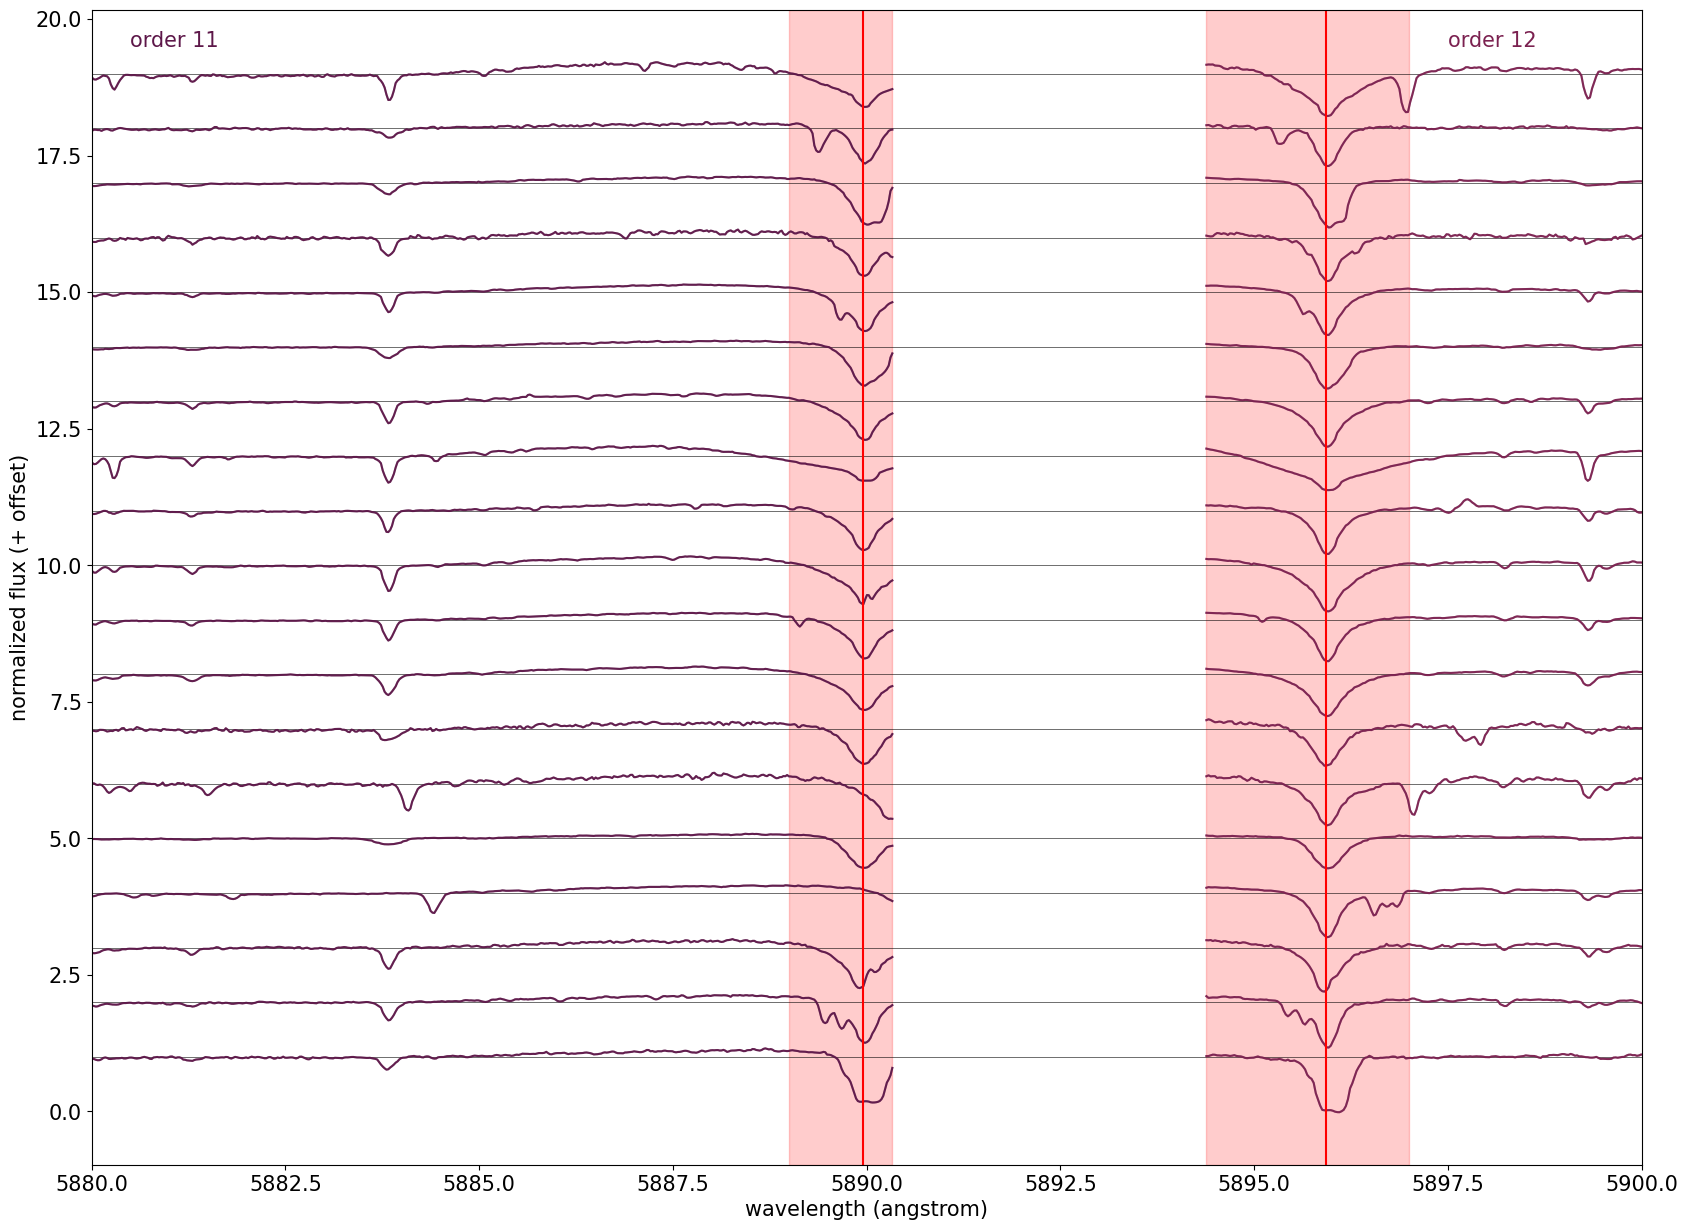

In [16]:
# plot of the adopted calcium doublet mask

order_path = './data/cks-spectra_shifted_resampled_r/'
order11 = pd.read_csv('./data/cks-spectra_dataframes/training_flux_order11.csv')
w11 = reference_w[10]

order12 = pd.read_csv('./data/cks-spectra_dataframes/training_flux_order12.csv')
w12 = reference_w[11]

i=0
figure(figsize=(20,15))
for target in order11.columns[9:28]:
    axhline(i+1, lw=0.4, color='k')
    
    plot(w11, order11[target]+i, c=cm.twilight(norm(11)), alpha=0.3)
    plot(w12, order12[target]+i, c=cm.twilight(norm(12)), alpha=0.3)
    
    plot(w11, order11[target]+i, c=cm.twilight(norm(11)), alpha=0.95)
    plot(w12, order12[target]+i, c=cm.twilight(norm(12)), alpha=0.95)
    i+=1
xlim(5880,5900)
text(5880.5,19.5,'order 11', c=cm.twilight(norm(11)))
text(5897.5,19.5,'order 12', c=cm.twilight(norm(12)))

# plot Ca doublet features
axvline(5889.950, color='r')
axvline(5895.924, color='r')

# plot adopted masks
axvspan(5889,w11[-1], color='r', alpha=0.2)
axvspan(w12[0],5897, color='r', alpha=0.2)

xlabel('wavelength (angstrom)');ylabel('normalized flux (+ offset)')

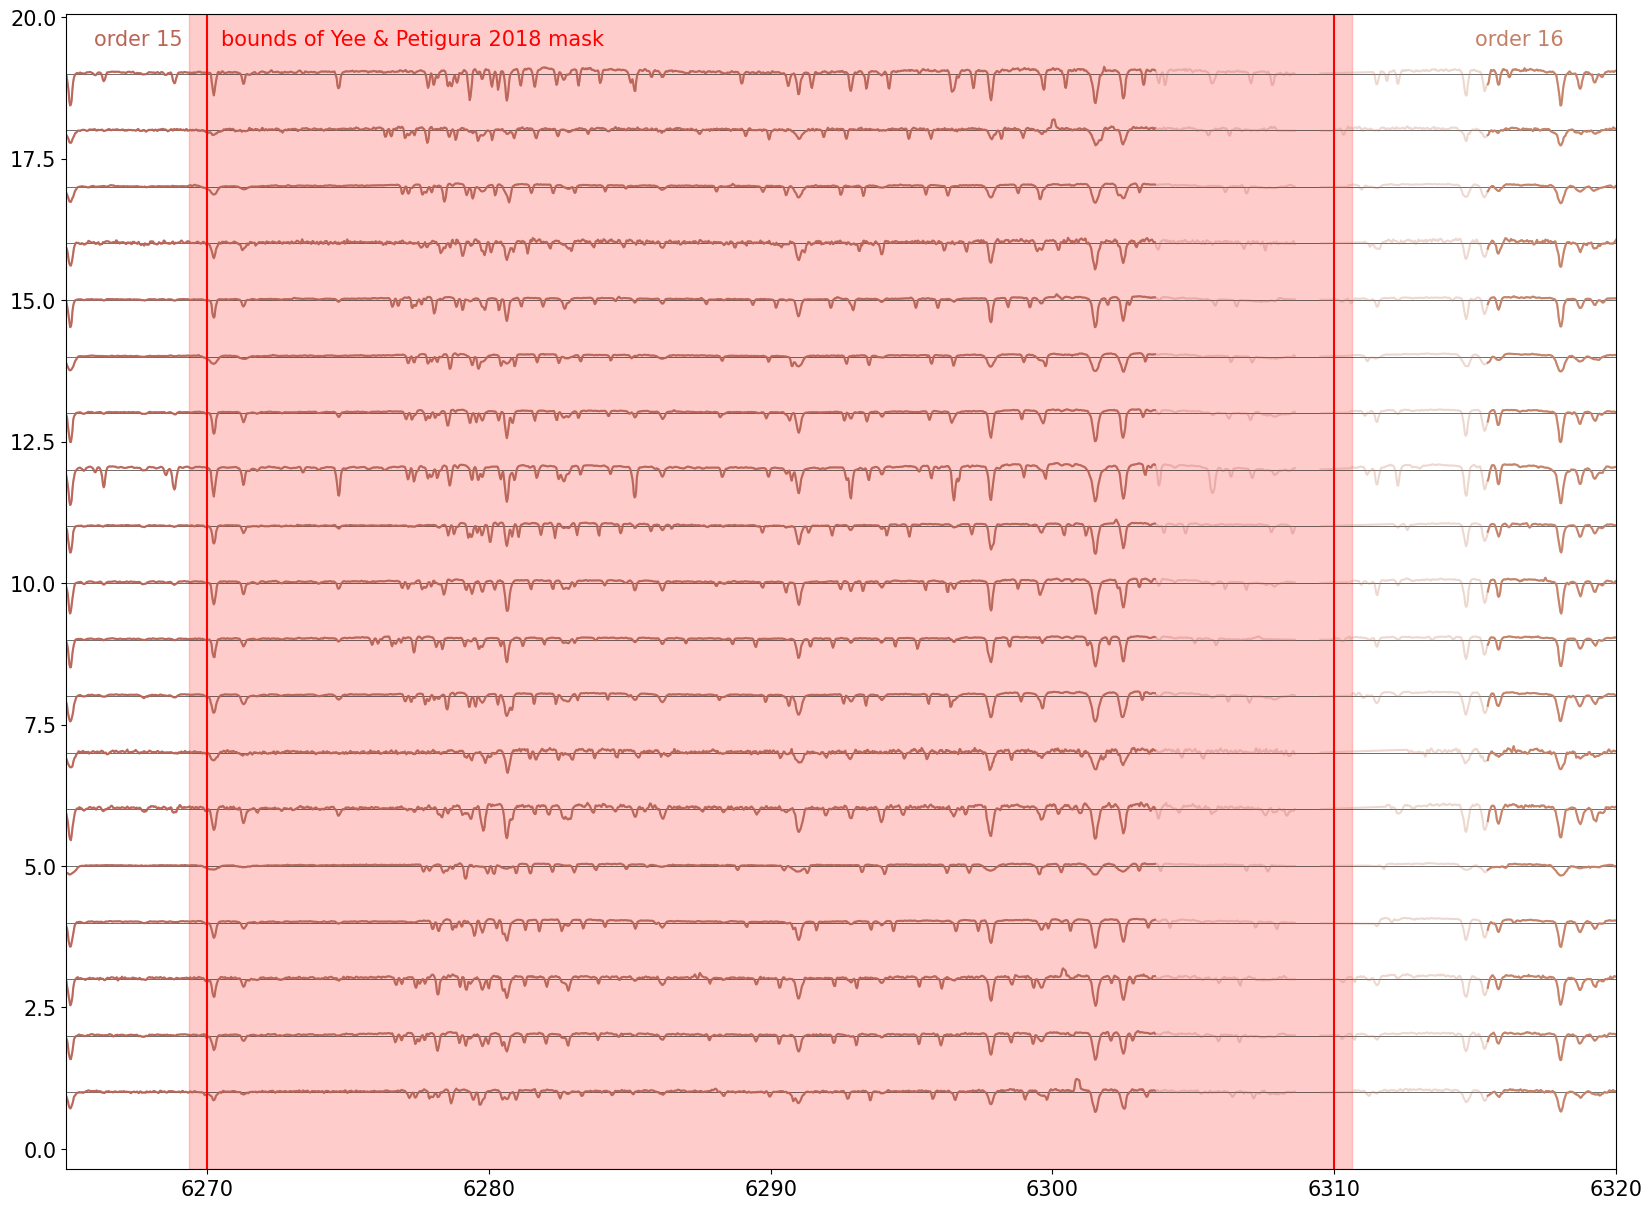

In [65]:
# plot of adopted telluric mask

order15 = pd.read_csv('./data/cks-spectra_dataframes/training_flux_order15.csv')
w15 = fits.open(order_path + 'order15/cks-k00001_rj122.742.fits')[1].data['w']

order126= pd.read_csv('./data/cks-spectra_dataframes/training_flux_order16.csv')
w16 = fits.open(order_path + 'order16/cks-k00001_rj122.742.fits')[1].data['w']

i=0
figure(figsize=(20,15))
for target in order11.columns[9:28]:
    axhline(i+1, lw=0.4, color='k')
    
    plot(w15[:-1], order15[target]+i, c=cm.twilight(norm(15)), alpha=0.3)
    plot(w16[:-1], order16[target]+i, c=cm.twilight(norm(16)), alpha=0.3)
    
    plot(w15[:-1][200:-200], order15[target][200:-200]+i, c=cm.twilight(norm(15)), alpha=0.95)
    plot(w16[:-1][200:-200], order16[target][200:-200]+i, c=cm.twilight(norm(16)), alpha=0.95)
    i+=1
xlim(6265,6320)
text(6266,19.5,'order 15', c=cm.twilight(norm(15)))
text(6315,19.5,'order 16', c=cm.twilight(norm(16)))
text(6270.5,19.5,'bounds of Yee & Petigura 2018 mask', c='r')

# plot telluric range from Yee&Petigura2018
axvline(6270, color='r')
axvline(6310, color='r')

import astropy.units as u
import astropy.constants as c
max_velocity_shift = 30*u.km/u.s
telluric_mask_min = (6270*u.angstrom*(1 - max_velocity_shift/c.c)).to(u.angstrom).value
telluric_mask_max = (6310*u.angstrom*(1 + max_velocity_shift/c.c)).to(u.angstrom).value
axvspan(telluric_mask_min, telluric_mask_max, color='r', alpha=0.2)

In [75]:
# print adopted masks:
print('telluric mask: {}-{} angstrom (padded region masked by Yee & Petigura 2018)'.format(
    np.round(telluric_mask_min,2), 
    np.round(telluric_mask_max,2)))
print('Na doublet mask: {}-{} angstrom'.format(
    5889.5,5896.5))

# notes: the sodium mask I've adopted is plotted above,
# the orders are overlapping but we clip this region (you can see from the opaque region)
# I chose a mask that looks like it encapsulated the Na doublet.
# question: does this look alright?
# question: should I be concerned about the ~10% of spectra that aren't well shifted?
# let me just update my notes for now.


telluric mask: 6269.37-6310.63 angstrom (padded region masked by Yee & Petigura 2018)
Na doublet mask: 5889.5-5896.5 angstrom
